In [2]:
import glob
import pandas as pd
import numpy as np
import scipy.optimize as op
from helper import phys
from helper.mcmcfit import mylinear_fit
from allsn_info import get_at2019dge

In [3]:
import matplotlib
import matplotlib.pyplot as plt
fs = 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [5]:
result = get_at2019dge(colorplt=False)
lc = result['tb']
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])
t0mjd = result['t_max']
dates = np.unique(lcdet["date"].values)
lcdet["phase"] = lcdet["mjd"].values - t0mjd

model files

In [6]:
files = glob.glob("../data/analysis/David_0130/clean/*.lightcurve")
files = np.array(files)
files = files[np.argsort(files)]
# ms = np.array([float(x.split("/")[-1].split("_")[0][1:]) for x in files]) # The ejecta mass (this grid is default 5Msun for all)
rs = np.array([float(x.split("/")[-1].split("_")[1][1:]) for x in files]) # The inner CSM radius
# kappas = np.array([float(x.split("/")[-1].split("_")[2][1:]) for x in files]) # the opacity (default at 0.2 cm^2/g)
aas = np.array([float(x.split("/")[-1].split("_")[3][1:]) for x in files]) # eta=M_csm/M_ej -- i.e. the CSM mass can be derived as aa*m
bs = np.array([float(x.split("/")[-1].split("_")[4][1:]) for x in files]) # beta=v_ej/c -- the characteristic ejecta velocity
# ds = np.array([float(x.split("/")[-1].split("_")[5][1:]) for x in files]) # dR/R -- the CSM width (fixed at 0.1)
# ss = np.array([float(x.split("/")[-1].split("_")[6][1:-11]) for x in files]) # the density slope (here assumed to be constant s=0)

Time (in seconds), Bolometric Luminosity (erg/s), Photospheric Radius (cm), Effective Temperature (K), and Color Temperature (K)

In [7]:
tb = pd.read_csv("../data/analysis/David_0130/bolgrid_1.csv")
tb = tb.sort_values(by = "Unnamed: 0")
#tb = tb[arg]

In [8]:
tb.head()

,Unnamed: 0,Mej,Rcsm,kappa,Mcsm,beta,delta,s,tau,bt,Lpeak,tpeak,max_ind,trise,tfall
0,/global/cscratch1/sd/dkhatami/csm_param_study/...,3,3.000000e+13,0.2,0.0051,0.01,0.1,0,1625.832656,16.258327,6.120000e+43,0.303728,44,0.055079,0.125061
1,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,1.000000e+14,0.2,0.5000,0.01,0.1,0,14345.582260,143.455823,1.260000e+44,2.268864,51,0.148691,0.307120
2,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,1.000000e+14,0.2,0.5000,0.03,0.1,0,14345.582260,430.367468,1.030000e+45,1.038000,93,0.055797,0.233903
3,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,1.000000e+14,0.2,0.5000,0.05,0.1,0,14345.582260,717.279113,2.290000e+45,0.784792,169,0.034411,0.324146
4,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,1.000000e+14,0.2,0.0500,0.01,0.1,0,1434.558226,14.345582,7.330000e+43,1.411603,58,0.317744,0.863999


In [9]:
tb["path"] = files
ix = tb["Lpeak"].values < 1e+42
tb1 = tb[ix]

In [10]:
len(tb)

225

In [11]:
len(tb1)

0

In [162]:
def get_Lbol_decline_rate(t, Lbol):
    """
    t in days
    Lbol in erg/s
    """
    # get peak light epoch
    id_peak = np.argsort(Lbol)[-1]
    t = t[id_peak:]
    Lbol = Lbol[id_peak:]
    
    t_end = t[0] + 4
    ix = (t<t_end)&(Lbol>1e+39)
    x = t[ix]
    y = np.log10(Lbol[ix])
    ey = np.ones(len(x))
    
    slope, eslope, offset = mylinear_fit(x, y, ey, npar = 2)
    
    tnew = np.linspace(min(x)-0.1, max(x)+0.1)
    lgLnew = slope * tnew + offset
    rate = -2.5 * (lgLnew[-1] - lgLnew[0]) / (tnew[-1] - tnew[0]) # mag per day
    return rate

In [163]:
rates = np.zeros(len(tb1))
for i in range(len(tb1)):
    fname = tb1["path"].values[i]
    data = np.loadtxt(fname).T
    t = data[0] / (24*3600)
    L = data[1]
    rate= get_Lbol_decline_rate(t, L)
    rates[i] = rate

In [164]:
tb1["rate5"] = rates
tb2 = tb1[tb1.rate5<0.45]
tb2 = tb2[tb2.tfall > 2]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [165]:
len(tb2)

4

<IPython.core.display.Javascript object>


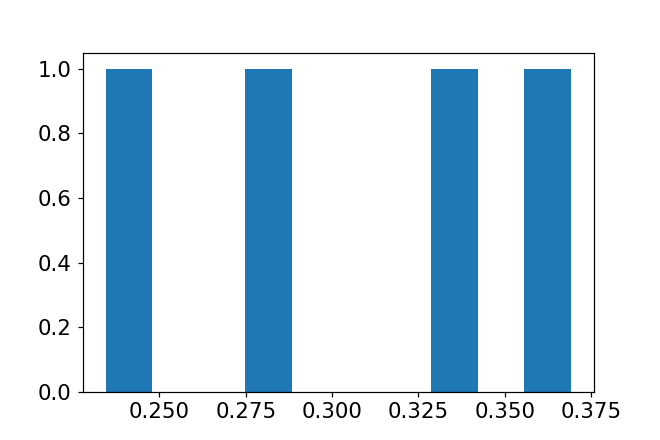

(array([1., 0., 0., 1., 0., 0., 0., 1., 0., 1.]),
 array([0.2344589 , 0.24792106, 0.26138321, 0.27484536, 0.28830751,
        0.30176967, 0.31523182, 0.32869397, 0.34215613, 0.35561828,
        0.36908043]),
 <a list of 10 Patch objects>)

In [166]:
#plt.figure(figsize=(6,4))
#plt.hist(tb2["rate5"])

Read the light curve of AT2019dge

In [173]:
data = pd.read_csv('../data/otherSN/Yao2020/bbdata.csv')
t_data = data['t'].values + 3
L_data = data['Lbb'].values
L_unc_data = data['Lbb_unc'].values
lgL_data = data['lgLbb'].values
lgL_unc_data = data['lgLbb_unc'].values

ind_rough = lgL_unc_data==0

<IPython.core.display.Javascript object>


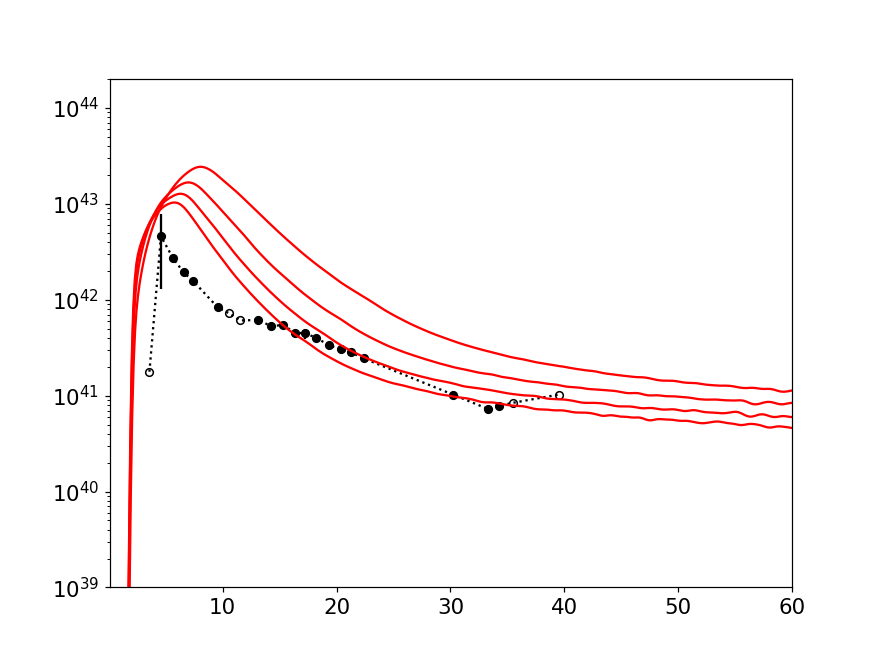

In [174]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i in range(len(tb2)):
    fname = tb2["path"].values[i]
    data = np.loadtxt(fname).T
    tfall =  tb2["tfall"].values[i]
    trise = tb2["trise"].values[i]
    if trise<2:
        color = "b"
    else:
        color = "r"
    ax.plot(data[0]/86400, data[1], color = color)
plt.semilogy()
ax.set_ylim(1e+39, 2e+44)
#plt.semilogx()
ax.set_xlim(0.1, 60)

ax.errorbar(t_data[~ind_rough], L_data[~ind_rough], L_unc_data[~ind_rough], fmt='ok', zorder = 1, markersize=5)
ax.plot(t_data[ind_rough], L_data[ind_rough], 'ok', mfc='white', zorder = 1, markersize=5)
ax.plot(t_data, L_data, ':k', zorder = 1)


In [175]:
tb2

,Unnamed: 0,Mej,Rcsm,kappa,Mcsm,beta,delta,s,tau,bt,Lpeak,tpeak,max_ind,trise,tfall,path,rate5
167,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,5.000000e+14,0.2,0.05,0.01,0.1,0,57.382329,0.573823,1.680000e+43,6.985670,53,3.236723,3.764967,../data/analysis/David_0130/clean/m5.0e+00_r5....,0.287553
175,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,5.000000e+14,0.2,0.10,0.01,0.1,0,114.764658,1.147647,2.440000e+43,8.123451,60,3.415891,4.259751,../data/analysis/David_0130/clean/m5.0e+00_r5....,0.234459
187,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,5.000000e+14,0.2,0.02,0.01,0.1,0,22.952932,0.229529,1.030000e+43,5.694771,45,2.724813,3.037034,../data/analysis/David_0130/clean/m5.0e+00_r5....,0.369080
195,/global/cscratch1/sd/dkhatami/csm_param_study/...,5,5.000000e+14,0.2,0.03,0.01,0.1,0,34.429397,0.344294,1.280000e+43,6.353875,49,3.132703,3.176616,../data/analysis/David_0130/clean/m5.0e+00_r5....,0.336474


In [176]:
np.unique(rs)

array([2.e+13, 3.e+13, 5.e+13, 8.e+13, 1.e+14, 2.e+14, 3.e+14, 5.e+14])

In [178]:
np.unique(bs)

array([0.01 , 0.03 , 0.033, 0.05 , 0.1  ])

In [180]:
np.unique(aas) * 5

array([0.005 , 0.0085, 0.01  , 0.02  , 0.03  , 0.05  , 0.1   , 0.2   ,
       0.3   , 0.5   ])

In [182]:
3e+10 / 1e+5 * 0.01 # km/s

3000.0

<IPython.core.display.Javascript object>


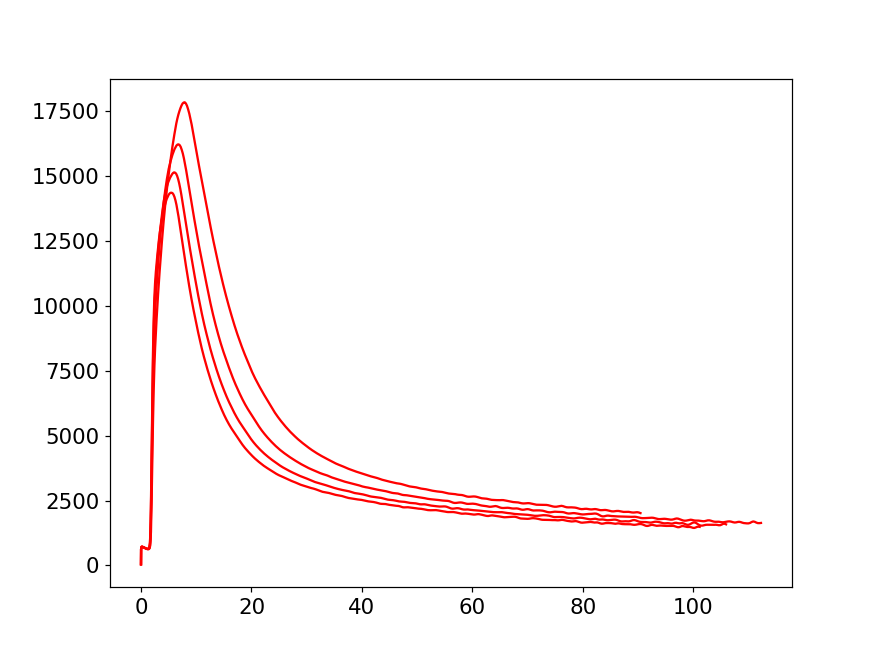

In [184]:
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i in range(len(tb2)):
    fname = tb2["path"].values[i]
    data = np.loadtxt(fname).T
    tfall =  tb2["tfall"].values[i]
    trise = tb2["trise"].values[i]
    if trise<2:
        color = "b"
    else:
        color = "r"
    ax.plot(data[0]/86400, data[3], color = color)


In [1]:
xyey = np.loadtxt('helper/Lbb_p15subtracted.txt')
tt = xyey[0]
lgL = xyey[1]
lgL_unc = xyey[2]

NameError: name 'np' is not defined